#### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/IASNLP"

/content/drive/MyDrive/IASNLP


# Importing Necessary Libraries

In [ ]:
!pip install sentencepiece
!pip install sacrebleu
!pip install tensorflow-gpu # ---> For GPU

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Embedding, LayerNormalization
import sentencepiece as spm
from sacrebleu.metrics import BLEU, CHRF, TER

import matplotlib.pyplot as plt

from collections import Counter

# Loading Data

We load the `train_data`, `train_dev_data`, `test_val_data` and `test_data` as well as the byte-pair encoder tokenizer for English and Bengali i.e. `sp_en_bpe` and `s_ben_bpe`.

In [ ]:
train_data, train_dev_data = pd.read_csv("train_data_big.csv")[['src', 'tgt']], pd.read_csv("train_dev.csv")[['src', 'tgt']] 
test_val_data, test_data = pd.read_csv("test_val.csv")[['src', 'tgt']], pd.read_csv("test_data.csv")[['src', 'tgt']]
sp_en_bpe, sp_ben_bpe = spm.SentencePieceProcessor(), spm.SentencePieceProcessor()
sp_en_bpe.load('eng_big_bpe.model'); sp_ben_bpe.load('ben_big_bpe.model');

# Data Preprocessing

We decide on some formats of the data and batches. We take the maximum tokens we can have per tokenized English and Bengali sentence to be `MAX_TOKENS = 60`. We use the vocabulary size of `32000`(i.e. `ENCODER_VOCAB = DECODER_VOCAB = 32000`). A batch size of `256` was choosen for our Mini-Batch Gradient Descent which is used to train our Model.

In [ ]:
MAX_TOKENS = 60
VOCAB_SIZE = 32000
BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE*4

The following two functions help in tokenizing an detokenizing the data based on our sentencepiece byte-pair encoding model.

In [ ]:
def tokenize(sentence, sp_model, add_bos = True, add_eos = True):
    bos = [sp_model.bos_id()] if add_bos else []
    eos = [sp_model.eos_id()] if add_eos else []
    inputs = bos + sp_model.encode_as_ids(sentence) + eos
    return np.reshape(np.array(inputs), [1, -1])
def detokenize(tokenized, sp_model, is_bos = True, is_eos = True):
    integers = np.squeeze(tokenized).tolist()
    if is_eos:
        return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.eos_id())])
    else:
        if sp_model.pad_id() in tokenized:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.pad_id())])
        else:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):])

We have tokenized the data.

In [ ]:
# Tokenization
src_train_data_enc = [np.squeeze(tokenize(train_data['src'].iloc[i], sp_en_bpe)) for i in range(train_data.shape[0])]
tgt_train_data_enc = [np.squeeze(tokenize(train_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_data.shape[0])]
src_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['src'].iloc[i], sp_en_bpe)) for i in range(train_dev_data.shape[0])]
tgt_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_dev_data.shape[0])]
src_test_val_data_enc = [np.squeeze(tokenize(test_val_data['src'].iloc[i], sp_en_bpe)) for i in range(test_val_data.shape[0])]
tgt_test_val_data_enc = [np.squeeze(tokenize(test_val_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(test_val_data.shape[0])]

We have padded the data with post-truncation and post padding upto MAX_TOKENS number of tokens.

In [ ]:
# Padding
# The reason why we add MAX_TOKENS+1 after-pad length for Bengali is that when we form the tf.Dataset later, we will shift the target sentence once and will truncate the last token once
# Hence, it will get adjusted
train_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_src = tf.keras.preprocessing.sequence.pad_sequences(src_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')

Below, we discard all those pairs where the tokenized source or target sentences are larger than MAX_TOKENS number of tokens.

In [ ]:
# Removing all pairs whose either the target sentence or source setence exceeds MAX_TOKENS number of tokens
same_idx = list(set([i for i in range(train_src.shape[0]) if train_src[i][-1] == 1 or train_src[i][-1] == 0]).intersection(set([i for i in range(train_tgt.shape[0]) if train_tgt[i][-1] == 1 or train_tgt[i][-1] == 0])))
train_src = train_src[same_idx]
train_tgt = train_tgt[same_idx]
same_idx = list(set([i for i in range(train_dev_src.shape[0]) if train_dev_src[i][-1] == 1 or train_dev_src[i][-1] == 0]).intersection(set([i for i in range(train_dev_tgt.shape[0]) if train_dev_tgt[i][-1] == 1 or train_dev_tgt[i][-1] == 0])))
train_dev_src = train_dev_src[same_idx]
train_dev_tgt = train_dev_tgt[same_idx]
same_idx = list(set([i for i in range(test_val_src.shape[0]) if test_val_src[i][-1] == 1 or test_val_src[i][-1] == 0]).intersection(set([i for i in range(test_val_tgt.shape[0]) if test_val_tgt[i][-1] == 1 or test_val_tgt[i][-1] == 0])))
test_val_src = test_val_src[same_idx]
test_val_tgt = test_val_tgt[same_idx]

In [ ]:
train_labels = np.zeros(train_tgt.shape)
train_labels[:,0:train_tgt.shape[1] -1] = train_tgt[:,1:]
train_dev_labels = np.zeros(train_dev_tgt.shape)
train_dev_labels[:,0:train_dev_tgt.shape[1] -1] = train_dev_tgt[:,1:]
test_val_labels = np.zeros(test_val_tgt.shape)
test_val_labels[:,0:test_val_tgt.shape[1] -1] = test_val_tgt[:,1:]

In [ ]:
print("*** Preprocessed Data ***")
print("Train Data Shape(Source): ", train_src.shape)
print("Train Data Shape(Target): ", train_tgt.shape)
print("Train Labels Shape(Target): ", train_labels.shape)
print("Train Dev Data Shape(Source): ", train_dev_src.shape)
print("Train Dev Data Shape(Target): ", train_dev_tgt.shape)
print("Train Dev Labels Shape(Target): ", train_dev_labels.shape)
print("Test Val Data Shape(Source): ", test_val_src.shape)
print("Test Val Data Shape(Target): ", test_val_tgt.shape)
print("Test Labels Shape(Target): ", test_val_labels.shape)

*** Preprocessed Data ***
Train Data Shape(Source):  (728047, 60)
Train Data Shape(Target):  (728047, 60)
Train Labels Shape(Target):  (728047, 60)
Train Dev Data Shape(Source):  (3649, 60)
Train Dev Data Shape(Target):  (3649, 60)
Train Dev Labels Shape(Target):  (3649, 60)
Test Val Data Shape(Source):  (1194, 60)
Test Val Data Shape(Target):  (1194, 60)
Test Labels Shape(Target):  (1194, 60)


Below we prepare the data in the form ready to feed to the Model.

In [ ]:
train_data_prep = tf.data.Dataset.from_tensor_slices((train_src, train_tgt, train_labels))
train_dev_data_prep = tf.data.Dataset.from_tensor_slices((train_dev_src, train_dev_tgt, train_dev_labels))
test_val_data_prep = tf.data.Dataset.from_tensor_slices((test_val_src, test_val_tgt, test_val_labels))

Below, we can see how our data looks

In [ ]:
for encoder_inputs, decoder_inputs, labels in train_data_prep.take(1):
    print(f'encoder_inputs.shape: {encoder_inputs.shape}')
    print(f'decoder_inputs.shape: {decoder_inputs.shape}')
    print(f"labels.shape: {labels.shape}")

encoder_inputs.shape: (60,)
decoder_inputs.shape: (60,)
labels.shape: (60,)


# Model

We will use the Transformer Architechture with the following hyperparameters.

In [ ]:
# Transformer parameters
d_model = 256 # 512 in the original paper
d_k = 32 # 64 in the original paper
d_v = 32 # 64 in the original paper
n_heads = 8 # 8 in the original paper
n_encoder_layers = 2 # 6 in the original paper
n_decoder_layers = 2 # 6 in the original paper

max_token_length = MAX_TOKENS # 512 in the original paper

In [ ]:
class SingleHeadAttention(Layer):
  def __init__(self, input_shape=(3, -1, d_model), dropout=.0, masked=None):
    super(SingleHeadAttention, self).__init__()
    self.q = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.normalize_q = Lambda(lambda x: x / np.sqrt(d_k))
    self.k = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.v = Dense(d_v, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.dropout = dropout
    self.masked = masked
  
  # Inputs: [query, key, value]
  def call(self, inputs, training=None):
    assert len(inputs) == 3
    # We use a lambda layer to divide vector q by sqrt(d_k) according to the equation
    q = self.normalize_q(self.q(inputs[0]))
    k = self.k(inputs[1])
    # The dimensionality of q is (batch_size, query_length, d_k) and that of k is (batch_size, key_length, d_k)
    # So we will do a matrix multication by batch after transposing last 2 dimensions of k
    # tf.shape(attn_weights) = (batch_size, query_length, key_length)
    attn_weights = tf.matmul(q, tf.transpose(k, perm=[0,2,1]))
    if self.masked: # Prevent future attentions in decoding self-attention
      # Create a matrix where the strict upper triangle (not including main diagonal) is filled with -inf and 0 elsewhere
      length = tf.shape(attn_weights)[-1]
      #attn_mask = np.triu(tf.fill((length, length), -np.inf), k=1) # We need to use tensorflow functions instead of numpy
      attn_mask = tf.fill((length, length), -np.inf)
      attn_mask = tf.linalg.band_part(attn_mask, 0, -1) # Get upper triangle
      attn_mask = tf.linalg.set_diag(attn_mask, tf.zeros((length))) # Set diagonal to zeros to avoid operations with infinity
      # This matrix is added to the attention weights so all future attention will have -inf logits (0 after softmax)
      attn_weights += attn_mask
    # Softmax along the last dimension
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    if training: # Attention dropout included in the original paper. This is possibly to encourage multihead diversity.
      attn_weights = tf.nn.dropout(attn_weights, rate=self.dropout)
    v = self.v(inputs[2])
    return tf.matmul(attn_weights, v)

class MultiHeadAttention_my(Layer):
  def __init__(self, dropout=.0, masked=None):
    super(MultiHeadAttention_my, self).__init__()
    self.attn_heads = list()
    for i in range(n_heads): 
      self.attn_heads.append(SingleHeadAttention(dropout=dropout, masked=masked))
    self.linear = Dense(d_model, input_shape=(-1, n_heads * d_v), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    
  def call(self, x, training=None):
    attentions = [self.attn_heads[i](x, training=training) for i in range(n_heads)]
    concatenated_attentions = tf.concat(attentions, axis=-1)
    return self.linear(concatenated_attentions)

class TransformerEncoder(Layer):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerEncoder, self).build(input_shape)
  def call(self, x, training=None):
    sublayer1 = self.multihead_attention((x, x, x), training=training)
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.linear2(self.linear1(layernorm1))
    sublayer1 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    return layernorm2
  def compute_output_shape(self, input_shape):
    return input_shape

class TransformerDecoder(Layer):
  def __init__(self, dropout=.0, attention_dropout=.0, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_self_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate, masked=True)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.multihead_encoder_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization3 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerDecoder, self).build(input_shape)
  def call(self, x, hidden, training=None):
    sublayer1 = self.multihead_self_attention((x, x, x))
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.multihead_encoder_attention((x, hidden, hidden))
    sublayer2 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    
    sublayer3 = self.linear2(self.linear1(layernorm1))
    sublayer3 = self.dropout3(sublayer3, training=training)
    layernorm3 = self.layer_normalization2(layernorm2 + sublayer3)
    return layernorm3
  def compute_output_shape(self, input_shape):
    return input_shape

class SinusoidalPositionalEncoding(Layer): # This is a TensorFlow implementation of https://github.com/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb
  def __init__(self):
    super(SinusoidalPositionalEncoding, self).__init__()
    self.sinusoidal_encoding = np.array([self.get_positional_angle(pos) for pos in range(max_token_length)], dtype=np.float32)
    self.sinusoidal_encoding[:, 0::2] = np.sin(self.sinusoidal_encoding[:, 0::2])
    self.sinusoidal_encoding[:, 1::2] = np.cos(self.sinusoidal_encoding[:, 1::2])
    self.sinusoidal_encoding = tf.cast(self.sinusoidal_encoding, dtype=tf.float32) # Casting the array to Tensor for slicing
  def call(self, x):
    return x + self.sinusoidal_encoding[:tf.shape(x)[1]]
  def compute_output_shape(self, input_shape):
    return input_shape
  def get_angle(self, pos, dim):
    return pos / np.power(10000, 2 * (dim // 2) / d_model)
  def get_positional_angle(self, pos):
    return [self.get_angle(pos, dim) for dim in range(d_model)]

class Transformer(Model):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.encoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.decoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.pos_encoding = SinusoidalPositionalEncoding()
    self.encoder = [TransformerEncoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_encoder_layers)]
    self.decoder = [TransformerDecoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_decoder_layers)]
    self.decoder_final = Dense(VOCAB_SIZE, input_shape=(None, d_model))
  def call(self, inputs, training=None): # Source_sentence and decoder_input
    source_sentence, decoder_input = inputs
    embedded_source = self.encoding_embedding(source_sentence)
    encoder_output = self.pos_encoding(embedded_source)
    for encoder_unit in self.encoder:
      encoder_output = encoder_unit(encoder_output, training=training)
    
    embedded_target = self.decoding_embedding(decoder_input)
    decoder_output = self.pos_encoding(embedded_target)
    for decoder_unit in self.decoder:
      decoder_output = decoder_unit(decoder_output, encoder_output, training=training)
    if training:
      decoder_output = self.decoder_final(decoder_output)
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    else:
      decoder_output = self.decoder_final(decoder_output[:, -1:, :])
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    return decoder_output

In [ ]:
transformer = Transformer(dropout=0.3) # Instantiating a new transformer model
train = [tf.cast(train_src, dtype=tf.float32), tf.cast(train_tgt, dtype=tf.float32)] # Cast the tuples to tensors
validation = [tf.cast(train_dev_src, dtype=tf.float32), tf.cast(train_dev_tgt, dtype=tf.float32)]

In [ ]:
transformer.load_weights("model_weights-2l-8h-loss-changed")

In [ ]:
transformer.build([train_src.shape, train_tgt.shape])
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8192000   
                                                                 
 embedding_1 (Embedding)     multiple                  8192000   
                                                                 
 sinusoidal_positional_encod  multiple                 0         
 ing (SinusoidalPositionalEn                                     
 coding)                                                         
                                                                 
 transformer_encoder (Transf  multiple                 789760    
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 789760    
 sformerEncoder)                                       

## Training

In [ ]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 10
checkpoint_filepath = './Models/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "accuracy",
    mode='max',
    save_best_only=True)

In [ ]:
with tf.device('/device:GPU:0'):
    history = transformer.fit(train, tf.cast(train_labels, dtype=tf.float32), batch_size=256, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
2844/2844 [==============================] - 1832s 635ms/step - loss: 1.3550 - accuracy: 0.8230
Epoch 2/10
2844/2844 [==============================] - 1807s 635ms/step - loss: 1.0616 - accuracy: 0.8379
Epoch 3/10
2844/2844 [==============================] - 1803s 634ms/step - loss: 0.9612 - accuracy: 0.8446
Epoch 4/10
2844/2844 [==============================] - 1802s 634ms/step - loss: 0.9044 - accuracy: 0.8491
Epoch 5/10
2844/2844 [==============================] - 1802s 634ms/step - loss: 0.8655 - accuracy: 0.8523
Epoch 6/10
2844/2844 [==============================] - 1799s 633ms/step - loss: 0.8359 - accuracy: 0.8549
Epoch 7/10
2844/2844 [==============================] - 1799s 633ms/step - loss: 0.8120 - accuracy: 0.8572
Epoch 8/10
2844/2844 [==============================] - 1799s 633ms/step - loss: 0.7917 - accuracy: 0.8591
Epoch 9/10
2844/2844 [==============================] - 1801s 633ms/step - loss: 0.7740 - accuracy: 0.8609
Epoch 10/10
2844/2844 [==============

In [ ]:
transformer.load_weights("model_weights-2L-8H-BigData")
#transformer.save_weights("model_weights-2L-8H-BigData")
# transformer.save("./Models/")

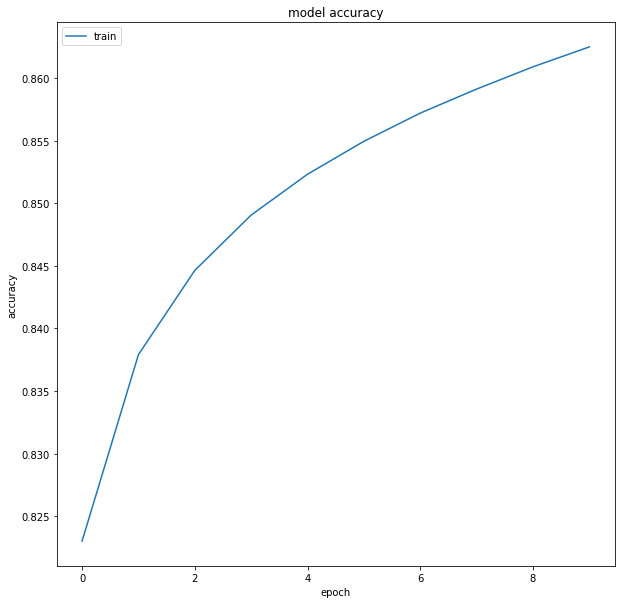

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

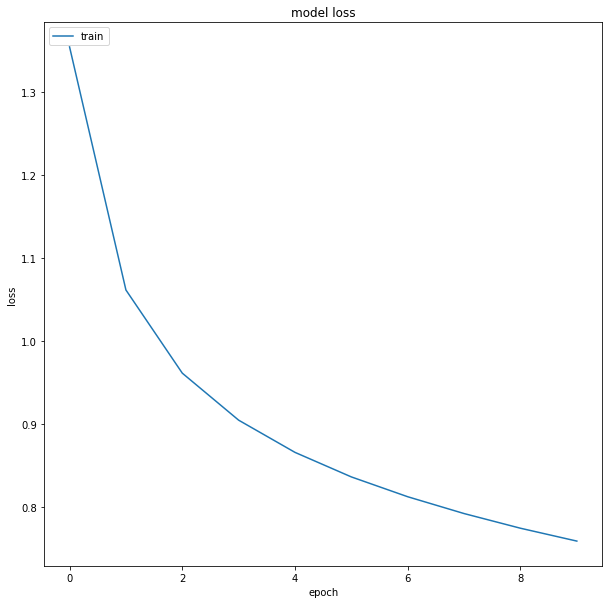

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# dot_img_file = "d_mod-"+str(d_model)+"-d_k-"+str(d_k)+"-d_v-"+str(d_v)+"-n_heads-"+str(n_heads)+"-enc_lays-"+str(n_encoder_layers)+"-dec_lays-"+str(n_decoder_layers)+'-transformer.png'
# tf.keras.utils.plot_model(transformer, to_file=dot_img_file, show_shapes=True)

In [ ]:
#transformer = keras.models.load_model('./Models/')

## Testing

In [ ]:
def greedy_translate(model, source_sentence, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    predict_label = tf.argmax(predict_output, axis=-1) # Pick the label with highest softmax score
    predict_seq = tf.concat([predict_seq, predict_label], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label[0][0].numpy())
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False)
  return detokenize(predict_sentence, sp_ben_bpe)

In [ ]:
import tensorflow_probability as tfp

In [ ]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  তোমাকে আমি ভালোবাসি।


In [ ]:
sentence = "I am tired."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I am tired.
Bengali Sentence:  আমি ক্লান্ত।


In [ ]:
sentences = list(test_val_data['src'][:250])
refs = [list(test_val_data['tgt'][:250])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [ ]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 2.82 23.4/6.0/1.8/0.5 (BP = 0.862 ratio = 0.871 hyp_len = 3121 ref_len = 3583)

In [ ]:
chrf = CHRF()
chrf.corpus_score(sys, refs)

chrF2 = 29.59

In [ ]:
ter = TER()
ter.corpus_score(sys, refs)

TER = 93.91

In [ ]:
val_perf = pd.DataFrame({'src':sentences, 'sys':sys, 'ref':refs[0]})
val_perf

,src,sys,ref
0,"Through her work, she spread the message of th...",তার কাজের মাধ্যমে তিনি পরিষ্কার ও পরিচ্ছন্নতা ...,নিজের কর্মেরউদাহরণ স্থাপন করে তিনি মানুষকে সেব...
1,Interacting with beneficiaries and store owner...,"প্রধানমন্ত্রী বলেন, কৃষি ও কৃষক বিক্রেতাদের সঙ...",সারা দেশের ৫ হাজারেরও বেশি স্থান থেকে দোকান মা...
2,These include:,এর মধ্যে রয়েছে:,এই প্রকল্পগুলির মধ্যে রয়েছে-
3,It is no surprise that today Japan is India’s ...,ভারত-জাপান বিনিয়োগের চতুর্থ বৃহত্তম উৎস।,জাপান যে বর্তমানে ভারতের চতুর্থ বৃহত্তম প্রত্য...
4,Record growth in last two and a half years,গত দুই বছরে রেকর্ড বৃদ্ধি পাচ্ছে,গত আড়াই বছরেরেকর্ড পরিমাণ অগ্রগতি
...,...,...,...
245,•India will emerge as a global leader in trans...,""""""" ⁇ echost infile in airer international aut...",· সর্বাধুনিক প্রযুক্তি এবং দক্ষ শ্রমিকের ব্যবহ...
246,BHIM stands for Bharat Interface for Money.,টাকার জন্য ভারতে অর্থ বরাদ্দ করা হচ্ছে।,BHIM মানে ভারত ইন্টারফেস ফর মানি।
247,"Heartiest congratulations, Beti Shivangi.","হৃদয়বিদারক, শিববাজার শিবের জন্য।",কন্যা শিবাঙ্গীকে অনেক অনেক অভিনন্দন!
248,"But, we are now awaiting the rains.",তবে এখন বৃষ্টির অপেক্ষায় রয়েছি।,বর্ষার প্রতীক্ষা চলছেই ।


In [ ]:
def sampling_translate(model, source_sentence, temperature=0.6, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  logprob = 0
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    probs = predict_output[-1].numpy()[0]
    log_probs = np.log(probs)
    u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    sample_idx = np.argmax(log_probs + g * temperature, axis=-1)
    sample_prob = predict_output[-1].numpy()[0][sample_idx]
    logprob += np.log(sample_prob)
    predict_label = np.arange(predict_output.shape[-1])[sample_idx] # Sample the label softmax score
    predict_seq = tf.concat([predict_seq, tf.cast([[predict_label]], dtype=tf.int32)], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label)
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False), logprob
  return detokenize(predict_sentence, sp_ben_bpe), logprob

In [ ]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  ('তোমাকে আমি ভালোবাসি।', -2.727547776303254)


In [ ]:
sentence = "I am hungry."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I am hungry.
Bengali Sentence:  ('আমি ক্ষুধার্ত।', -2.0784402698773192)


In [ ]:
def generate_samples(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = [], []
    for _ in range(n_samples):
        sample, logp = sampling_translate(model, sentence, temperature)
        samples.append(sample)
        log_probs.append(logp)
    return samples, log_probs

In [ ]:
def rouge1_similarity(system, reference):
    sys_counter = Counter(system)
    ref_counter = Counter(reference)
    overlap = 0
    for token in sys_counter:
        token_count_sys = sys_counter[token]
        token_count_ref = ref_counter[token]
        overlap += min(token_count_ref, token_count_sys)
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    if precision + recall != 0:
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0     
    return rouge1_score

In [ ]:
def weighted_avg_overlap(samples, log_probs):
    scores = {}
    for index_candidate, candidate in enumerate(samples):    
        overlap, weight_sum = 0.0, 0.0
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):           
            if index_candidate == index_sample:
                continue
            sample_p = float(np.exp(logp))
            weight_sum += sample_p
            sample_overlap = rouge1_similarity(candidate, sample)
            overlap += sample_p * sample_overlap
        score = overlap / weight_sum
        scores[index_candidate] = score
    return scores

In [ ]:
def mbr_decode(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = generate_samples(sentence, n_samples, model, temperature)
    scores = weighted_avg_overlap(samples, log_probs)
    max_score_key = max(scores, key=scores.get)
    return Counter({sample:score for sample, score in zip(samples, scores.values())})

In [ ]:
def mbr_decode(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = generate_samples(sentence, n_samples, model, temperature)
    scores = weighted_avg_overlap(samples, log_probs)
    max_score_key = max(scores, key=scores.get)
    return samples[max_score_key]

In [ ]:
rand_idx = np.random.randint(0, test_val_data.shape[0], 10)
sentences = list(test_val_data['src'][rand_idx])
refs = [list(test_val_data['tgt'][rand_idx])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [ ]:
val_perf = pd.DataFrame({'src':sentences, 'sys':sys, 'ref':refs[0]})
val_perf.values

array([['At a public event to mark the 75th anniversary of the hoisting of Tricolour on Indian soil by Netaji Subhas Chandra Bose, the Prime Minister released a commemorative postal stamp, coin, and First Day Cover.',
        'প্রধানমন্ত্রীরদপ্তর নেতাজি সুভাষ বসুর জন্মবার্ষিকী উপলক্ষে প্রধানমন্ত্রীর কার্যালয়ের ৭৫তম বর্ষপূর্তি উপলক্ষে আয়োজিত এক অনুষ্ঠানে প্রধানমন্ত্রীর কার্যালয়ের ৭৫তম বর্ষপূর্তি উপলক্ষে আয়োজিত এক অনুষ্ঠানে প্রধানমন্ত্রীর কার্যালয়ের ৭৫তম বর্ষপূর্তি উপলক্ষে এই তথ্য প্রকাশ করা হয়।',
        'ভারতীয় ভূ-খন্ডে নেতাজী সুভাষ চন্দ্র বসুর জাতীয় পতাকা উত্তোলনের ৭৫তম বার্ষিকী উদযাপন উপলক্ষে আয়োজিত এক জনসভায় প্রধানমন্ত্রী স্মারক ডাকটিকিট মুদ্রা এবং ছোট পুস্তিকা প্রকাশ করেন।'],
       ['Kochi ranks first in the total number of international and domestic tourist arrivals in Kerala.',
        'কোচি ভারতের কেরালা রাজ্যের মোট আন্তর্জাতিক ও আন্তর্জাতিক পর্যটকদের মধ্যে প্রথম স্থান দখল করে রেখেছে।',
        'কেরলে আগত দেশ-বিদেশের পর্যটকদের সংখ্যার নিরিখেকোচির স্থান রয়েছে প্রথমেই।'],
 

In [ ]:
rand_idx = np.random.randint(0, test_val_data.shape[0], 10)
sentences = list(test_val_data['src'][rand_idx])
refs = [list(test_val_data['tgt'][rand_idx])]
sys = [mbr_decode(sentence, 5, transformer) for sentence in sentences]

In [ ]:
test_val_data

,src,tgt
0,"Through her work, she spread the message of th...",নিজের কর্মেরউদাহরণ স্থাপন করে তিনি মানুষকে সেব...
1,Interacting with beneficiaries and store owner...,সারা দেশের ৫ হাজারেরও বেশি স্থান থেকে দোকান মা...
2,These include:,এই প্রকল্পগুলির মধ্যে রয়েছে-
3,It is no surprise that today Japan is India’s ...,জাপান যে বর্তমানে ভারতের চতুর্থ বৃহত্তম প্রত্য...
4,Record growth in last two and a half years,গত আড়াই বছরেরেকর্ড পরিমাণ অগ্রগতি
...,...,...
1190,"The MoU was signed in April, 2017.",বৈঠকে নেতৃত্ব দেন প্রধানমন্ত্রী স্বয়ং।
1191,Top officials of the Ministry of Health and Fa...,পর্যালোচনা বৈঠকে এছাড়াও উপস্থিত ছিলেন স্বাস্থ্...
1192,Sports are considered a waste of time in our s...,"সমাজে এখনও মনে করা হয়, খেলাধুলো করা মানে সময় ন..."
1193,The MoU covers the following areas of cooperat...,"এই মউ-এ সহযোগিতার যেসব ক্ষেত্র রয়েছে, তার মধ্য..."


In [ ]:
val_perf = pd.DataFrame({'src':sentences, 'sys':sys, 'ref':refs[0]})
val_perf.values

array([['His demise is anguishing.', 'তাঁর মৃত্যু মহাসমাঢ়।',
        'তাঁরমৃত্যু এক দুঃখবহ ঘটনা।'],
       ['This is the ninth interaction in the series by the Prime Minister through video conference with the beneficiaries of various Government schemes.',
        'প্রধানমন্ত্রীর বিভিন্ন প্রকল্পের মাধ্যমে এই আলোচনা সভা ছাড়াও প্রধানমন্ত্রী বিভিন্ন ধরনের সচিবদের সঙ্গে আলাপ-আলোচনা করবেন।',
        'বিভিন্ন সরকারি কর্মসূচির সুফল গ্রহীতাদের সঙ্গে ভিডিও সম্মেলনের মঞ্চে এটি ছিল প্রধানমন্ত্রীর নবম মতবিনিময় অনুষ্ঠান।'],
       ['He said that the Union Government is working with an approach of “isolation to integration” to develop all the hitherto under-developed parts of the country.',
        'প্রধানমন্ত্রী বলেছেন, দেশের সার্বিক উন্নয়নের লক্ষ্যে কেন্দ্রীয় সরকার একযোগে কাজ করছে।',
        'দেশে উন্ন্যনের দিক থেকে পিছিয়ে পড়া অংশগুলির সার্বিক অগ্রগতির জন্য ‘বিচ্চিন্ন না রেখে সেগুলিকেও বিকাশের পথে সামিল করার’ লক্ষ্যে কেন্দ্রীয় সরকার কাজ করছে বলে তিনি উল্লেখ করেন।'],
       ['After laying the Fo

In [ ]:
rand_idx = np.random.randint(0, train_dev_data.shape[0], 10)
sentences = list(train_dev_data['src'][rand_idx])
refs = [list(train_dev_data['tgt'][rand_idx])]
sys = [mbr_decode(sentence, 5, transformer) for sentence in sentences]
val_perf = pd.DataFrame({'src':sentences, 'sys':sys, 'ref':refs[0]})
val_perf.values

array([["Rouhani's speech was the most secular and non-ideologic one we can expect for, even from an Iranian opposition member.",
        'রুহানি বক্তৃতাটি ছিল ধর্মনিরপেক্ষ এবং অহিংস ধর্মনিরপেক্ষ নন, এমনকি আমরা ইরানি নেতা হতে পারি।',
        'রুহানির বক্তৃতা ছিল সবচেয়ে ধর্মনিরপেক্ষ ও অভাবাদর্শগত যা আমরা ইরানীরা এমনকি বিরোধীদের কাছ থেকেও তা আশা করতে পারি।'],
       ['Ministry of Home Affairs NCMC reviews preparedness as Super Cyclonic Storm AMPHAN set to make landfall on 20th May, 2020 The storm is likely to impact the coastal districts of Jagatsinghpur, Kendrapada, Bhadrak, Jajpur and Balasore in Odisha and East Medinipur, South North 24 Parganas, Howrah, Hooghly, and Kolkata in West Bengal.',
        'কেন্দ্রীয় স্বরাষ্ট্রমন্ত্রক মে মাসের মধ্যে ওড়িশা ও রাঁচিতে ওড়িশা উপকূলে ঘূর্ণিঝড়ের পূর্বাভাস নয়াদিল্লি, ০৬ মে, ২০১৯ ঝাড়খন্ড রাজ্য জুড়ে ঘূর্ণিঝড়ের আশঙ্কা রয়েছে।',
        'স্বরাষ্ট্র মন্ত্রক আগামী ২০ মে ঘূর্ণীঝড় ‘আমফান’ আছড়ে পরার আগে জাতীয় বিপর্যয় মোকাবিলা কমিটির বৈঠকে প্রস্

In [ ]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 0.77 29.7/3.3/0.6/0.4 (BP = 0.361 ratio = 0.495 hyp_len = 101 ref_len = 204)

In [ ]:
sentence = "I love you."
translated_sentence = mbr_decode(sentence, 2, transformer, 1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I love you.
Bengali:  আমি তোকে ভালোবাসি।


In [ ]:
sentence = "How are you."
translated_sentence = mbr_decode(sentence, 2, transformer, 1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  How are you.
Bengali:  Counter({'কী করে ও।': 0.5263157894736842, 'কীভাবে রে.': 0.5263157894736842})


In [ ]:
sentence = "How are you."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  How are you.
Bengali:  Counter({'কেমন আছো?': 0.907040457536224, 'কেমন আছো।': 0.8788338511150703, 'কেমন আছিস?': 0.8088943187030939, 'কেমন আছিস।': 0.775763082543881, 'কেমন আছো তুমি?': 0.7478567775109081, 'কেমন আছিস তুমি।': 0.6394157638852587, 'কেমন আছিস কেমন আছো।': 0.6085890806922252})


In [ ]:
sentence = "I am hungry."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I am hungry.
Bengali:  Counter({'আমি ক্ষুধার্ত।': 0.9502494667158244, 'আমার ক্ষুধার্ত।': 0.8756310302192929, 'ক্ষুধার্ত।': 0.818353761385797, 'আমার ক্ষুধা লাগে।': 0.6987997312123394, 'ক্ষুধার্ত হয়ে গেছি।': 0.6950869641448076, 'আমার ক্ষুধা লাগছে।': 0.6845285738001278, 'আমাকে ক্ষুধার্ত হয়ে গেছে।': 0.642837053359326})


In [ ]:
sentence = "I like Durga Puja very much."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I like Durga Puja very much.
Bengali:  Counter({'আমি দুর্গা পূজা করতে খুব পছন্দ করি।': 0.768293151605951, 'আমার কাছে দুর্গা পূজা খুব ভাল লাগে।': 0.7640135070643919, 'আমি দুর্গা পূজা খুব ভালোবাসি।': 0.7587386319806901, 'আমার খুব ভাল লাগে দুর্গা পুজো।': 0.7530364877758167, 'পূজারী আমার খুব ভালো লাগে।': 0.7276894856586514, 'আমি দুর্গা পূজা খুব পছন্দ করি।': 0.7184708876440703, 'পূজা কাজ করতে আমার খুব ভাল লাগে।': 0.705220485169725, 'আমার পুজোও খুবই ভালো।': 0.6523371217053519, 'পূজা বেশ ভালো লাগামছুম।': 0.6351569800562059, 'পুজো করতে আমার ভীষণ ভালো লাগে।': 0.6342014494720721})


In [ ]:
sentence = "Hi, Guys!"
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Hi, Guys!
Bengali:  Counter({'জলদি করো!': 0.6187844186545642, 'ওরে, দোস্ত !': 0.37254380153996874, 'জলদি!': 0.35038201315708506, 'হেই, দোস্ত!': 0.34490235870783087, 'আরে, দোস্তরা!': 0.3217876802340611, 'ভাই, ভাইজান!': 0.2732671188946071, 'হে, ভাই!': 0.25662007484830174, 'থামো!': 0.23470112324010795, 'হে, হে, হে, হে!': 0.1652472070994243})


In [ ]:
sentence = "Thank You!"
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Thank You!
Bengali:  Counter({'ধন্যবাদ!': 0.9957039981370857, 'ধন্যবাদও!': 0.9377215277168133, 'ধন্যবাদ।': 0.8768335887941671})


In [ ]:
sentence = "Bye Bye."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Bye Bye.
Bengali:  Counter({'ছেড়ে চলে যাও।': 0.5805542103163154, 'ছেড়ে দাও!': 0.5182108138518735, 'ছেড়ে দাও।': 0.4078346927849338, 'চলে যাও।': 0.38100068015765043, 'হাজে.': 0.2748886613009933, 'বিজেব।': 0.22165568581155864, 'পারবি।': 0.21377546188349406, 'গো।': 0.19436175881867584, 'এফ.আই.': 0.04035940625772109, 'মো.': 0.00217028232099727})


In [ ]:
sentence = "Let's Start!"
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Let's Start!
Bengali:  Counter({'চলো, শুরু করি!': 0.7271354570256302, 'চলো শুরু করছি!': 0.7252760925234333, 'চলো শুরু করি!': 0.6721222851434028, 'চলো, শুরু!': 0.6564186828588761, 'শুরু করে আসি!': 0.5926268540512329, 'শুরু করি!': 0.5563705283608691, 'শুরু হয়!': 0.46908118720063824, 'চলো!': 0.46409532695196937, 'চল!': 0.31974337859256274})
